# 과제1: tensorflow를 이용한 NN 밑바닥부터 구현
input feature가 100개이고,  
hidden layer가 2개이고 neuron이 각각 50,10개이고,  
output이 5개인 NN를 구현해 보자  
* hidden layer는 relu를 activation function으로, output layer는 softmax를 activation function으로 사용

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
n_x = 100
n_h1 = 50
n_h2 = 10
n_y = 5

In [3]:
# Simulate train set
m = 500

x_train=np.random.randn(m,n_x).astype(np.float32)
y_train=np.zeros((m,n_y)).astype(np.float32)
y_train[np.arange(m),np.random.randint(n_y,size=m)]=1

print(x_train)
print(y_train)

[[ 5.48890591e-01 -2.17611361e+00 -3.63143742e-01 ... -6.13070667e-01
  -3.07843853e-02  3.40333521e-01]
 [ 2.39330864e+00 -1.05872619e+00  1.08248210e+00 ... -4.09124464e-01
   2.97923446e-01 -1.12189716e-02]
 [-2.12832522e+00  4.32890922e-01 -1.02907097e+00 ... -1.84506154e+00
  -3.88537616e-01  1.42806768e+00]
 ...
 [ 3.16055804e-01  1.29956845e-02  8.61672044e-01 ...  4.52112854e-01
  -5.86848736e-01  1.36962092e+00]
 [ 5.46822071e-01  1.39872301e+00  1.99265599e+00 ... -1.39233127e-01
  -1.37064970e+00 -9.20264006e-01]
 [-1.92791951e-04  1.20336342e+00 -2.24304438e-01 ...  7.51087844e-01
   1.36403799e+00 -1.05742693e+00]]
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]


* Initialization of weights

In [4]:
w1=tf.Variable(1e-3*np.random.randn(n_x,n_h1).astype(np.float32),name="w1")
## 코드를 작성해 보세요 ##
w2=tf.Variable(1e-3*np.random.randn(n_h1,n_h2).astype(np.float32),name='w2')
w3=tf.Variable(1e-3*np.random.randn(n_h2,n_y).astype(np.float32),name='w3')

* forward propagation을 통해 prediction 값을 구하고, loss를 구하는 function을 만들어 봅시다

In [5]:
def forward(x):
    z1=tf.matmul(x,w1)
    a1=tf.nn.relu(z1)
    ## 코드를 작성해 보세요 ##
    z2=tf.matmul(a1,w2)
    a2=tf.nn.relu(z2)
    z3=tf.matmul(a2,w3)
    predictions = tf.nn.relu(z3)
    
    return predictions

def loss_fn(predictions, y):
    loss= -tf.reduce_sum(y*tf.math.log(predictions))
    return loss    

* backpropagation & update parameters

In [6]:
learning_rate=1e-2
optimizer=tf.keras.optimizers.Adam(learning_rate)

def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = forward(x)
        loss = loss_fn(predictions, y)
    ## 코드를 작성해 보세요 ## (hint: tape.gradient를 구글링 해보세요)
    gradient = tape.gradient(loss, x)
    # optimizer와 위에서 구한 경사도를 이용해 가중치들을 업데이트 합니다.
    optimizer.apply_gradients(zip(gradient, [w1, w2]))
    return loss, w1, w2


* 간단하게 train loop를 작성해 loss가 줄어나가는지 확인해 봅시다.

In [9]:
loss_list = []

for step in range(10): 
    loss, w1, w2 = train_step(x_train, y_train)
    loss_list.append(loss.numpy())
    
print(loss_list)

AttributeError: 'numpy.ndarray' object has no attribute '_id'

# 과제2: MNIST 데이터를 나만의 NN model로 95 % 이상의 성능으로 training 시켜보자!


## Loading MNIST training data

In [7]:
from tensorflow import keras

# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scaling(image data는 min-max scaling 주로 사용)
x_train = x_train/255.0
x_test = x_test/255.0

## Training Data
28 * 28 pixel 값을 가진 총 60000개의 이미지 데이터

In [8]:
x_train.shape 

(60000, 28, 28)

Neural network 모델에 맞게 이미지 데이터를 벡터 형태로 데이터를 reshape 합니다.  
(Model을 만들 때 *keras.layers.Flatten(input_shape=(28, 28)) 이용해도 됨)

In [17]:
x_train, x_test = x_train.reshape((-1, 28, 28)), x_test.reshape((-1, 28, 28))
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

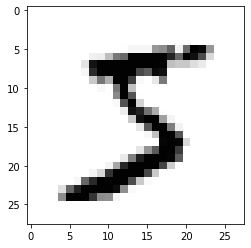

In [18]:
plt.imshow(x_train[0]).set_cmap('Greys')

## Training Labels
이미지 데이터가 나타내는 숫자값을 label로 가지고 있고, 0부터 9까지의 값을 나타냄  
마찬가지로, 60000개의 label이 존재

In [19]:
y_train.shape

(60000,)

In [20]:
# show MNIST label for above data
y_train[0]

5

## 나만의 모델을 tensorflow keras API 를 이용해 만들어 봅시다~

* parameters for model

In [21]:
activation_list = ["sigmoid", "relu", "softmax", "tanh"]

loss_list = ["sparse_categorical_crossentropy",
             "categorical_crossentropy", 
             "binary_crossentropy"]

optimizer_list = ["sgd", "adam", "rmsprop", "adagrad"]

initializer_list = [tf.keras.initializers.RandomNormal(), 
                    tf.keras.initializers.RandomUniform(), 
                    tf.keras.initializers.he_normal(), 
                    tf.keras.initializers.he_uniform(), 
                    tf.keras.initializers.GlorotUniform(),
                    tf.keras.initializers.GlorotNormal()]

# dropout
dropout_rate = 0.3
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation = "sigmoid"),
    tf.keras.layers.Dense(2, activation = "sigmoid"),
    tf.keras.layers.Dropout(dropout_rate)
])


# regularizer
regularizer = tf.keras.regularizers.l1(1e-3)
regularizer = tf.keras.regularizers.l2(1e-3)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation="sigmoid",
                          activity_regularizer=regularizer)
])

# weight initialization
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation="sigmoid",
                          kernel_initializer=initializer_list[0])
])

#### My Own Model 

In [22]:
#### 자유롭게 Model을 만들고 compile 해봅시다 ####

dropout_rate = 0.3
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, 28)),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(10, activation = "sigmoid"),
    tf.keras.layers.Dropout(dropout_rate)
])


model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

내가 만든 모델을 확인해 봅시다.

In [23]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2570      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


model을 자유롭게 train 해봅시다.  

In [24]:
model.fit(x_train, y_train, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 1.7168 - accuracy: 0.6061
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9102 - accuracy: 0.6691
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.8309 - accuracy: 0.6776
Epoch 4/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.8019 - accuracy: 0.6811
Epoch 5/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.7775 - accuracy: 0.6851


95%이상의 성능을 가진 모델을 만들면 완성!

In [25]:
test_loss, test_acc = model.evaluate(x_test,y_test, verbose=2)

print('\nAccuracy:', test_acc)

313/313 - 1s - loss: 0.1304 - accuracy: 0.9719

Accuracy: 0.9718999862670898


![](https://www.tensorflow.org/versions/master/images/mnist_tensorboard.png)